In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv('../data/wine-quality-preprocessed.csv')
df.head()

,volatile acidity,residual sugar,chlorides,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.70,0.641854,-2.577022,3.526361,0.9978,3.51,0.56,2.240710,0
1,0.88,0.955511,-2.322788,4.204693,0.9968,3.20,0.68,2.282382,0
2,0.76,0.832909,-2.385967,3.988984,0.9970,3.26,0.65,2.282382,0
3,0.28,0.641854,-2.590267,4.094345,0.9980,3.16,0.58,2.282382,1
4,0.70,0.641854,-2.577022,3.526361,0.9978,3.51,0.56,2.240710,0


In [9]:
df[(df['quality'] > 0)]

,volatile acidity,residual sugar,chlorides,total sulfur dioxide,density,pH,sulphates,alcohol,quality
3,0.28,0.641854,-2.590267,4.094345,0.99800,3.16,0.58,2.282382,1
7,0.65,0.182322,-2.733368,3.044522,0.99460,3.39,0.47,2.302585,1
8,0.58,0.693147,-2.617296,2.890372,0.99680,3.36,0.57,2.251292,1
14,0.28,0.587787,-2.385967,4.634729,0.99690,3.30,0.75,2.351375,1
16,0.22,0.587787,-2.563950,4.094345,0.99680,3.39,0.53,2.240710,1
...,...,...,...,...,...,...,...,...,...
1471,0.51,0.832909,-2.577022,3.688879,0.99574,3.42,0.75,2.397895,1
1472,0.62,0.641854,-2.688248,3.637586,0.99651,3.42,0.82,2.251292,1
1474,0.55,0.788457,-2.780621,3.931826,0.99512,3.52,0.76,2.415914,1
1475,0.51,0.832909,-2.577022,3.688879,0.99574,3.42,0.75,2.397895,1


In [11]:
class NaiveBayes:
    def __init__(self, X_train, y_train):
        self.y_train = y_train
        self.X_train = X_train
        self.df = pd.concat([X_train, y_train], axis=1)
        
        
    def prior_probability(self, values):
        l = []
        n = self.y_train.count()
        for v in values:
            p = self.y_train[(self.y_train == v)].count()
            l.append(p/n)
        return l

    def likelyhood_probability(self,feature,x, label, value):
        #only considering values with given outcome
        df = self.df[(self.df[label] == value)]
        mean = df[feature].mean()
        sd = df[feature].std()
        #build gaussian distribution PDF
        prob = (1 / (sd * np.sqrt(2 * np.pi))) * (np.exp(-(1/2) * ((x-mean)/sd)**2))
        return prob

    def predict(self,X, label):
        
        features = list(X.columns)
        values = np.unique(df[label])
        #print(values)
        prior = self.prior_probability(values=values)
        #print(prior)
        y_pred = []
        for index, row in X.iterrows():
            likelyhood = [1] * len(values)
            for v in range(len(values)):
                for f in features:
                    p = self.likelyhood_probability(f,row[f],label,values[v])
                    likelyhood[v] *= p
        
            post = [0,0]
            for l in range(2):
                post[l] = likelyhood[l] * prior[l]
        
            #print(post)
            y_pred.append(np.argmax(post))
        return np.array(y_pred)
    

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'quality'], df['quality'], test_size=0.33, random_state=42)
#train = X_train
#train['quality'] = y_train

#y_pred = naive_bayes(train, X=X_test)
model = NaiveBayes(X_train,y_train)
y_pred= model.predict(X_test,'quality')
print(confusion_matrix(y_test, y_pred))
print("Naive Bayes f1: ",f1_score(y_test, y_pred))
print("Naive Bayes accuracy: ",accuracy_score(y_test, y_pred))

print('---------sklearn--------')

clf = GaussianNB()
clf.fit(X_train,y_train)
y_pred_clf = clf.predict(X_test)
print("Sklearn Naive Bayes f1: ",f1_score(y_test, y_pred_clf))
print("Sklearn Naive Bayes accuracy: ",accuracy_score(y_test, y_pred_clf))

# build confusion matrix
def confusionMtx(y_pred, y_test):
    data = {'y_actual':    y_test,'y_predicted': y_pred}
    df = pd.DataFrame(data)
    confusion_matrix = pd.crosstab(df['y_actual'], df['y_predicted'], rownames=['Actual'], colnames=['Predicted'])
    print(confusion_matrix)





[[166  72]
 [ 74 176]]
Naive Bayes f1:  0.7068273092369478
Naive Bayes accuracy:  0.7008196721311475
---------sklearn--------
Sklearn Naive Bayes f1:  0.7068273092369478
Sklearn Naive Bayes accuracy:  0.7008196721311475


In [16]:
# cross validation
from sklearn.metrics import confusion_matrix as cm


def perform(clf, train_set, test_set):
    # remove labels from data
    xtr = train_set.loc[:, train_set.columns != 'quality']
    ytr = train_set['quality']
    xt = test_set.loc[:, test_set.columns != 'quality']
    yt = test_set['quality']
    model = NaiveBayes(xtr,ytr)
    y_pred= model.predict(xt,'quality')
    #print(len(y_pred))
    #print('----')
    #print(len(yt.to_numpy()))
    #print("CV Naive Bayes accuracy: ",accuracy_score(yt, y_pred))
    return(accuracy_score(yt, y_pred))


k = 5
folds = np.array_split(df, k)
accuracy_scores = []
for i in range(k):
    train = folds.copy() 
    test = folds[i]
    del train[i]
    train = pd.concat(train, sort=False)
    accuracy_scores.append(perform(clf, train.copy(), test.copy()))
    
print(k, ' fold CV Score: ', np.mean(accuracy_scores))


5  fold CV Score:  0.7266743014200641


Confusion matrix

 [[166  72]
 [ 74 176]]

True Positives(TP) =  166

True Negatives(TN) =  176

False Positives(FP) =  72

False Negatives(FN) =  74


<AxesSubplot:>

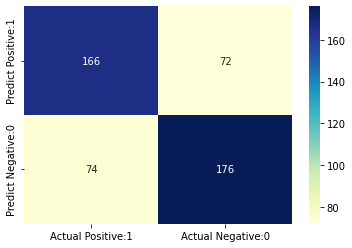

In [17]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
#Here we see that its quite a downing trend in the volatile acidity as we go higher the quality 


<AxesSubplot:xlabel='quality', ylabel='volatile acidity'>

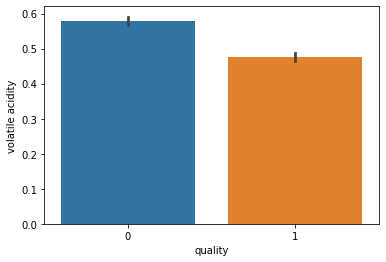

In [19]:
sns.barplot(x = 'quality', y = 'volatile acidity', data = df)


<AxesSubplot:xlabel='quality', ylabel='chlorides'>

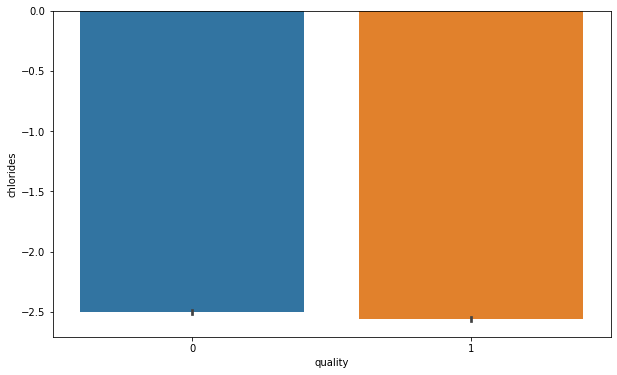